In [103]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [104]:
# Paths to your local dataset
base_dir = '/kaggle/input/rp-rice-leaf-dataset/Rice Leaf Diseases Dataset'

In [105]:
# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

In [108]:
# Data augmentation for training set to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split 20% for validation
)

# No augmentation for validation set, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training and validation data from directories
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use the training subset
)

validation_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)

Found 12800 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.


In [109]:
# Load the ResNet50 model with pretrained weights from ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [110]:
# Freeze the base model (so layers won't be trained)
base_model.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Another dropout layer
predictions = Dense(4, activation='softmax')(x)  # 4 classes: Brown Spot, Leaf Blast, Bacterial Leaf Blight, Healthy

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()



Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [112]:
# Set early stopping and model checkpoint to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

In [117]:
# Train the model with more epochs and callbacks
history = model.fit(
    train_generator,
    epochs=20,  # Increased epochs for better training
    validation_data=validation_generator,
    callbacks=[early_stopping,model_checkpoint],
    class_weight=class_weights_dict
)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 277s 662ms/step - accuracy: 0.3915 - loss: 1.2904 - val_accuracy: 0.3122 - val_loss: 1.4264
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 250s 617ms/step - accuracy: 0.3874 - loss: 1.2869 - val_accuracy: 0.3681 - val_loss: 1.4114
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 249s 615ms/step - accuracy: 0.3951 - loss: 1.2805 - val_accuracy: 0.3666 - val_loss: 1.4272
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 251s 620ms/step - accuracy: 0.3913 - loss: 1.2844 - val_accuracy: 0.3550 - val_loss: 1.4479
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 251s 618ms/step - accuracy: 0.4054 - loss: 1.2823 - val_accuracy: 0.3778 - val_loss: 1.4229
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 269s 636ms/step - accuracy: 0.3948 - loss: 1.2746 - val_accuracy: 0.3469 - val_loss: 1.3742
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 250s 615ms/step - accuracy: 0.3942 - loss: 1.2698 - val_accuracy: 0.3728 - val_loss: 1.4246
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 258s 635ms/step - accuracy: 0.3918 -

In [118]:
# Unfreeze the base model and fine-tune
base_model.trainable = True

# Compile again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
              loss='categorical_crossentropy', metrics=['accuracy'])

In [119]:
# Train the model with more epochs and callbacks
history_fine = model.fit(
    train_generator,
    epochs=20,  # Increased epochs for better training
    validation_data=validation_generator,
    callbacks=[early_stopping,model_checkpoint],
    class_weight=class_weights_dict
)

Epoch 1/20


I0000 00:00:1728410393.767293     133 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads



400/400 ━━━━━━━━━━━━━━━━━━━━ 381s 809ms/step - accuracy: 0.4129 - loss: 3.9449 - val_accuracy: 0.1731 - val_loss: 5.0823
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 255s 628ms/step - accuracy: 0.7439 - loss: 0.6210 - val_accuracy: 0.3162 - val_loss: 3.3975
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 257s 633ms/step - accuracy: 0.8663 - loss: 0.3355 - val_accuracy: 0.6934 - val_loss: 1.5296
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 264s 637ms/step - accuracy: 0.9321 - loss: 0.2096 - val_accuracy: 0.7209 - val_loss: 2.0535
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 255s 629ms/step - accuracy: 0.9532 - loss: 0.1347 - val_accuracy: 0.7387 - val_loss: 2.1726
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 258s 636ms/step - accuracy: 0.9636 - loss: 0.1079 - val_accuracy: 0.7453 - val_loss: 2.7577
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 255s 629ms/step - accuracy: 0.9760 - loss: 0.0746 - val_accuracy: 0.7406 - val_loss: 2.9424
Epoch 8/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 254s 626ms/step - accuracy: 0.9762 - loss: 0.06

In [123]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.2f}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 632ms/step - accuracy: 0.1952 - loss: 5.3936
Validation accuracy: 0.68


In [124]:
# Import necessary libraries for plotting and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 629ms/step


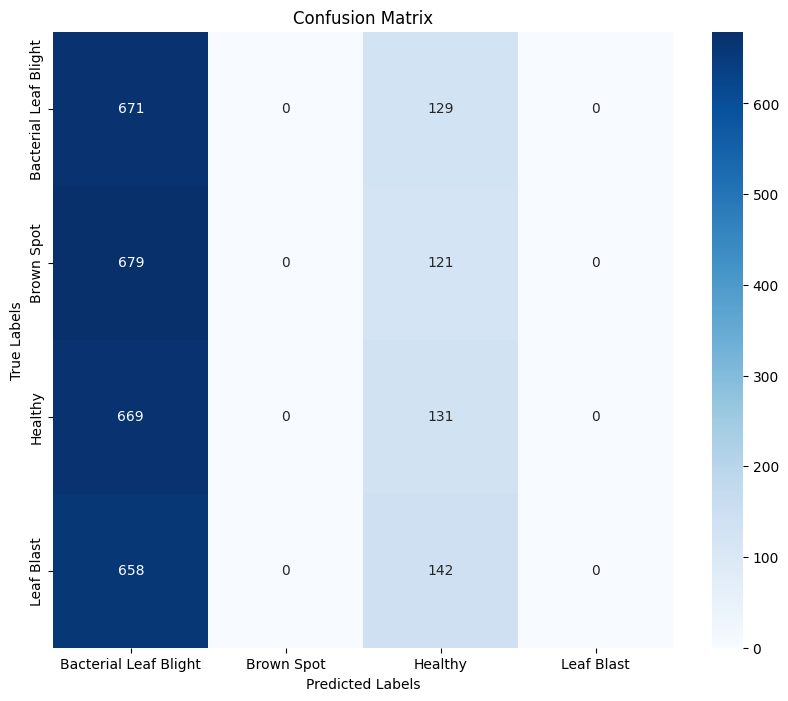

Classification Report:
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.25      0.84      0.39       800
           Brown Spot       0.00      0.00      0.00       800
              Healthy       0.25      0.16      0.20       800
           Leaf Blast       0.00      0.00      0.00       800

             accuracy                           0.25      3200
            macro avg       0.13      0.25      0.15      3200
         weighted avg       0.13      0.25      0.15      3200



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
# Predict the validation data
val_preds = model.predict(val_generator)
val_preds_classes = np.argmax(val_preds, axis=1)

# Get true labels
val_true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Classification report
print('Classification Report:')
print(classification_report(val_true_classes, val_preds_classes, target_names=class_labels))